In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns


In [2]:
#get jobzone df
jz = pd.read_excel('datasets/job_zone.xlsx')
jz.columns = jz.columns.str.lower().str.replace(" ","_")
jz = jz.drop(labels=['date', 'domain_source','o*net-soc_code'], axis=1)   
jz = jz.rename(columns={'job_zone':'zone'})

In [3]:
# Set folder path
folder_name = "results/job_match_trial"

# Get all JSON files
json_files = [f for f in os.listdir(folder_name) if f.endswith('.json')]

#get the model name. stop at the second underscore
model_name = [json_files[:-15] for json_files in json_files]


In [4]:
model_name

['deepseek8b_no_prompt',
 'deepseek8b_prompt_1',
 'llama3b_no_prompt',
 'llama3b_prompt_1',
 'mistral7b_no_prompt',
 'mistral7b_prompt_1']

In [5]:
def mean_perfect_array(df):
    #get the mean difference in df, by iteration, into a np array
    return df.groupby("iteration")["perfect_match"].mean().to_numpy()

def mean_related_array(df):
    #get the mean difference in df, by iteration, into a np array
    return df.groupby("iteration")["related"].mean().to_numpy()

In [177]:
perfect_array_list = []
related_array_list = []

# Loop through each JSON file and load it into the DataFrame
for json_file in json_files:
    df = pd.read_json(f"{folder_name}/{json_file}").dropna()
    #drop the iteration column'
    df = df.drop(labels=['rating'], axis=1)
    #normalize related score to 0-1
    df['related'] = df['related']/10
    #get the mean difference in df, by iteration, into a np array
    perfect_array = mean_perfect_array(df)
    related_array = mean_related_array(df)
    perfect_array_list.append(perfect_array)
    related_array_list.append(related_array)

In [180]:
perfect_array_list
# print(perfect_array_list[0])
# print(perfect_array_list[1])

[array([0.10638298, 0.17021277, 0.12765957, 0.10638298, 0.10638298,
        0.06382979, 0.14893617, 0.06382979, 0.14893617, 0.10638298]),
 array([0.29787234, 0.34042553, 0.19148936, 0.23404255, 0.31914894,
        0.21276596, 0.27659574, 0.29787234, 0.31914894, 0.29787234]),
 array([0.31914894, 0.23404255, 0.17021277, 0.21276596, 0.17021277,
        0.23404255, 0.19148936, 0.23404255, 0.23404255, 0.27659574]),
 array([0.36170213, 0.34042553, 0.36170213, 0.31914894, 0.36170213,
        0.29787234, 0.36170213, 0.31914894, 0.36170213, 0.25531915]),
 array([0.23404255, 0.12765957, 0.17021277, 0.10638298, 0.19148936,
        0.21276596, 0.14893617, 0.17021277, 0.14893617, 0.12765957]),
 array([0.19148936, 0.19148936, 0.19148936, 0.19148936, 0.23404255,
        0.17021277, 0.23404255, 0.17021277, 0.21276596, 0.23404255])]

Descriptive Statistics:
deepseek8b_no_prompt: Mean = 0.1149, Variance = 0.0011
deepseek8b_prompt_1: Mean = 0.2787, Variance = 0.0022
llama3b_no_prompt: Mean = 0.2277, Variance = 0.0019
llama3b_prompt_1: Mean = 0.3340, Variance = 0.0012
mistral7b_no_prompt: Mean = 0.1638, Variance = 0.0015
mistral7b_prompt_1: Mean = 0.2021, Variance = 0.0006

Levene's Test for Equal Variances: p-value = 0.8041

ANOVA Results:
F-statistic: 39.7847
p-value: 0.0000
Result: Reject the null hypothesis. There is a significant difference between the groups.


C:\Users\godfr\AppData\Local\Temp\ipykernel_5288\694043641.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


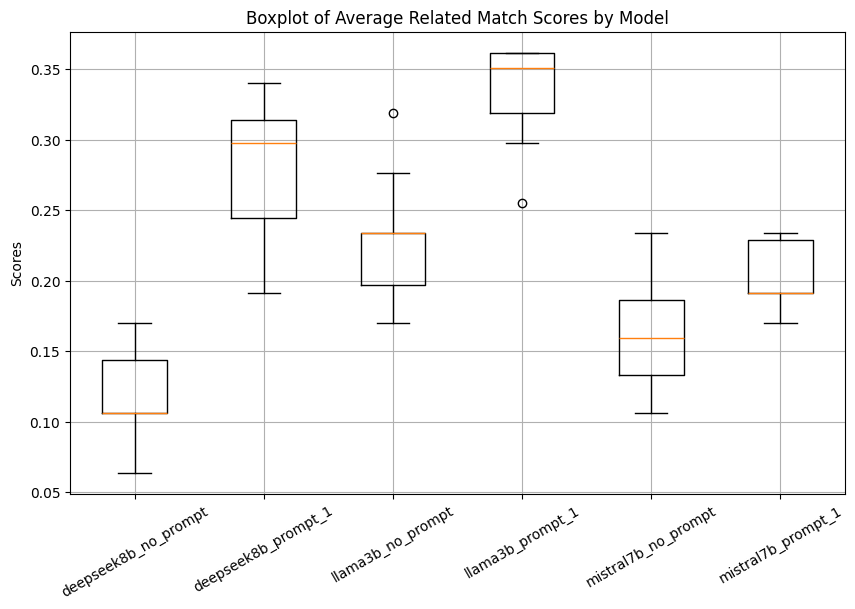

In [181]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

groups = perfect_array_list
labels = model_name

# Descriptive stats
print("Descriptive Statistics:")
for label, group in zip(labels, groups):
    print(f"{label}: Mean = {np.mean(group):.4f}, Variance = {np.var(group):.4f}")

# Check for equal variances (Levene's test)
levene_stat, levene_p = stats.levene(*groups)
print(f"\nLevene's Test for Equal Variances: p-value = {levene_p:.4f}")
if levene_p < 0.05:
    print("Warning: Variances may not be equal (p < 0.05). Consider a robust alternative if significant.")

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Result: Fail to reject the null hypothesis. No significant difference between the groups.")

# Boxplot for visualization
plt.figure(figsize=(10, 6))
plt.boxplot(groups, labels=labels)
plt.ylabel('Scores')
plt.title('Boxplot of Average Related Match Scores by Model')
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

In [90]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine data for Tukey HSD
all_data = np.concatenate(groups)
group_labels = np.concatenate([[label] * 10 for label in labels])

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=all_data, groups=group_labels, alpha=0.05)
print("\nTukey HSD Post-Hoc Test:")
print(tukey)


Tukey HSD Post-Hoc Test:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1             group2      meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------
deepseek_no_prompt deepseek_prompt_1   0.1638    0.0  0.1116   0.216   True
deepseek_no_prompt   llama_no_prompt   0.1128    0.0  0.0606   0.165   True
deepseek_no_prompt    llama_prompt_1   0.2191    0.0   0.167  0.2713   True
deepseek_no_prompt mistral_no_prompt   0.0489 0.0781 -0.0033  0.1011  False
deepseek_no_prompt  mistral_prompt_1   0.0872 0.0001   0.035  0.1394   True
 deepseek_prompt_1   llama_no_prompt  -0.0511 0.0585 -0.1033  0.0011  False
 deepseek_prompt_1    llama_prompt_1   0.0553 0.0317  0.0031  0.1075   True
 deepseek_prompt_1 mistral_no_prompt  -0.1149    0.0 -0.1671 -0.0627   True
 deepseek_prompt_1  mistral_prompt_1  -0.0766 0.0009 -0.1288 -0.0244   True
   llama_no_prompt    llama_prompt_1   0.1064    0.0  0.0542  

In [185]:
import numpy as np
from scipy import stats
from statsmodels.stats.power import TTestPower
x = 4
no_prompt_model = model_name[x]
prompt_1_model = model_name[x+1]

no_prompt = related_array_list[x] 
prompt_1 = related_array_list[x+1]  

# Paired t-test (H1: Prompt1 > No Prompt)
t_stat, p_value_two_tailed = stats.ttest_rel(prompt_1, no_prompt)
p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1 - (p_value_two_tailed / 2)
print(f"Paired t-test ({prompt_1_model} > {no_prompt_model}):")
print(f"t-statistic: {t_stat:.4f}, p-value (one-tailed): {p_value_one_tailed:.8f}")

# Interpretation
alpha = 0.05
if p_value_one_tailed < alpha and np.mean(prompt_1) > np.mean(no_prompt):
    print("Result: Reject H₀. Prompt1 significantly improves scores.")
else:
    print("Result: Fail to reject H₀. Prompt1 does not significantly improve scores.")

# Cohen's d (for paired data)
diffs = prompt_1 - no_prompt
cohen_d = np.mean(diffs) / np.std(diffs, ddof=1)
print(f"Cohen's d: {cohen_d:.4f}")

# Power analysis (paired t-test)
power_analysis = TTestPower()
sample_size = power_analysis.solve_power(effect_size=abs(cohen_d), nobs=None, alpha=alpha, power=0.8, alternative='larger')
print(f"Required sample size (runs): {int(np.ceil(sample_size))} (for power = 0.8, alpha = 0.05)")

Paired t-test (mistral7b_prompt_1 > mistral7b_no_prompt):
t-statistic: 4.0830, p-value (one-tailed): 0.00137290
Result: Reject H₀. Prompt1 significantly improves scores.
Cohen's d: 1.2911
Required sample size (runs): 6 (for power = 0.8, alpha = 0.05)


In [6]:
# lets look at no prompt df
def get_result(df):
    score_df = df.groupby("title").agg({
        "perfect_match": "mean",
        "related": "mean",
        "ind": "first"
    }).reset_index()
    #merge with jz
    score_df = score_df.merge(right=jz, left_on="title", right_on="title")
    return score_df

In [10]:
# Loop through each JSON file and load it into the DataFrame
for json_file in json_files:
    df = pd.read_json(f"{folder_name}/{json_file}").dropna()
    #drop the iteration column'
    df = df.drop(labels=['rating'], axis=1)
    #normalize related score to 0-1
    df['related'] = df['related']/10
    descriptive_stat = get_result(df).describe()[["perfect_match", "related"]].iloc[1:3]
    print(json_file, "\n" ,descriptive_stat)


deepseek8b_no_prompt_processed.json 
       perfect_match   related
mean       0.117391  0.046522
std        0.180499  0.057008
deepseek8b_prompt_1_processed.json 
       perfect_match   related
mean       0.284783  0.117609
std        0.347670  0.137763
llama3b_no_prompt_processed.json 
       perfect_match   related
mean       0.232609  0.108043
std        0.345160  0.139214
llama3b_prompt_1_processed.json 
       perfect_match   related
mean       0.341304  0.173261
std        0.404187  0.167585
mistral7b_no_prompt_processed.json 
       perfect_match   related
mean       0.167391  0.063478
std        0.295939  0.117667
mistral7b_prompt_1_processed.json 
       perfect_match   related
mean       0.206522  0.086739
std        0.358641  0.153392


In [67]:
x = 0
df = pd.read_json(f"{folder_name}/{json_files[x]}").dropna()
#drop the iteration column'
df = df.drop(labels=['rating'], axis=1)
#normalize related score to 0-1
df['related'] = df['related']/10
df = get_result(df)
print(json_files[x])
df["zone"].value_counts()

deepseek8b_no_prompt_processed.json


zone
2    15
4    12
3    12
5     7
Name: count, dtype: int64

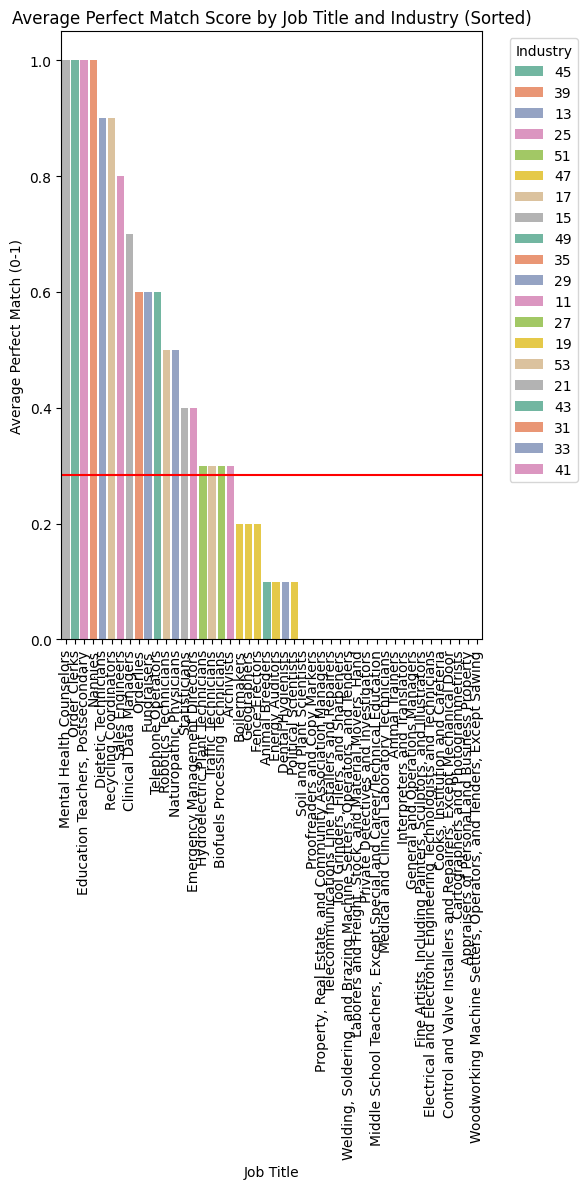

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame (e.g., no_prompt_df)
df["ind"] = df["ind"].astype(str)
df["zone"] = df["zone"].astype(str)

# Calculate mean perfect_match per title to determine sort order
order = df.groupby("title")["perfect_match"].mean().sort_values(ascending=False).index

# Create figure
plt.figure(figsize=(6, 12))

# Bar plot: mean perfect_match by title, colored by ind, sorted descending
sns.barplot(data=df, x="title", y="perfect_match", hue="ind", palette="Set2", order=order)
#add a mean score
plt.axhline(y= df["perfect_match"].sum() / len(df), color='r', linestyle='-')

# Customize
plt.xticks(rotation=90)
plt.title('Average Perfect Match Score by Job Title and Industry (Sorted)')
plt.xlabel('Job Title')
plt.ylabel('Average Perfect Match (0-1)')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plot
plt.show()

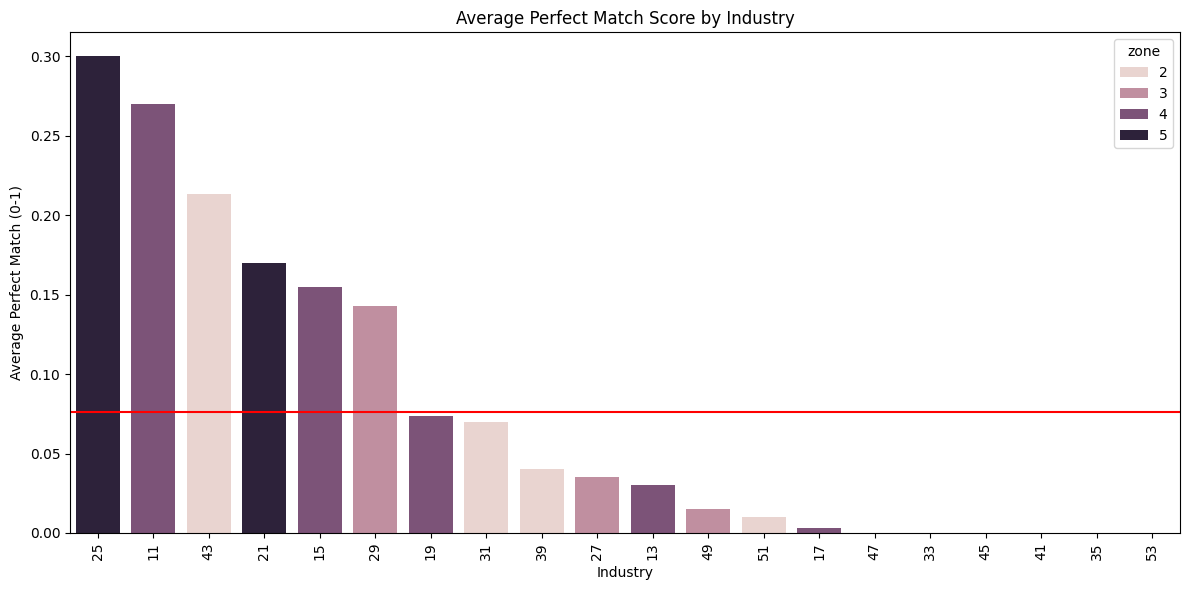

In [62]:
ind_plot = df[["ind", "perfect_match", "related", "zone"]].groupby("ind").agg({"perfect_match":"mean", "related":"mean", "zone":"first"}).reset_index()

# plot perfect match by industry
plt.figure(figsize=(12, 6))
# sns.barplot(data=ind_plot, x="ind", y="perfect_match", order=ind_plot.sort_values("perfect_match", ascending=False)["ind"], hue="zone")
sns.barplot(data=ind_plot, x="ind", y="related", order=ind_plot.sort_values("related", ascending=False)["ind"], hue="zone")
# add a mean score line
plt.axhline(y= ind_plot["related"].mean(), color='r', linestyle='-')
plt.xticks(rotation=90)
plt.title('Average Perfect Match Score by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Perfect Match (0-1)')
plt.tight_layout()
plt.show()


In [64]:
zone_plot = df[["zone", "perfect_match", "related"]].groupby("zone").agg({"perfect_match":"mean", "related":"mean"}).reset_index()
#sort by perfect match
# zone_plot = zone_plot.sort_values("perfect_match", ascending=False)
zone_plot = zone_plot.sort_values("related", ascending=False)

zone_plot

,zone,perfect_match,related
3,5,0.528571,0.171429
2,4,0.108333,0.147500
0,2,0.233333,0.047333
1,3,0.083333,0.025833


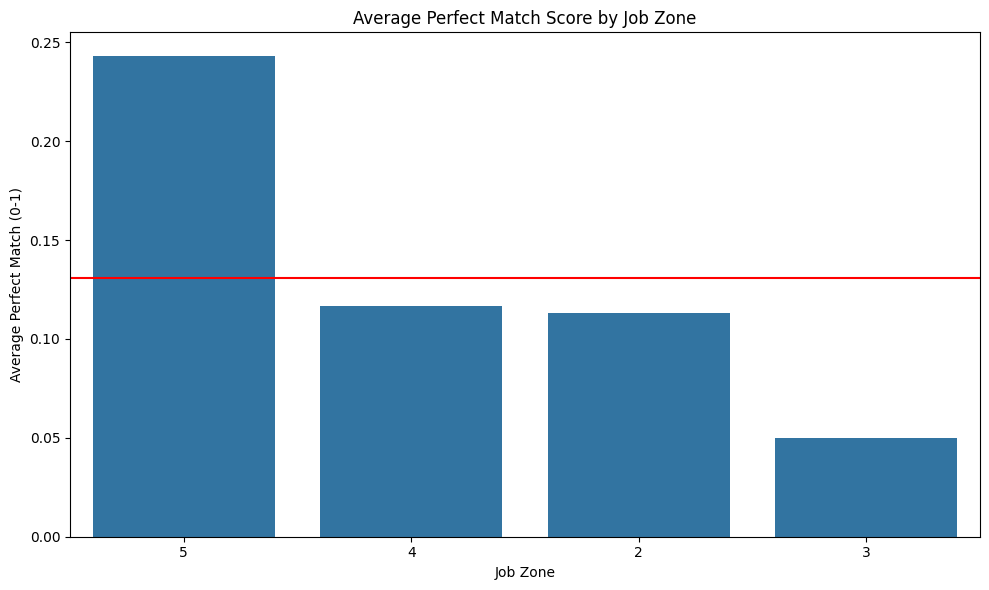

In [27]:
# plot perfect match by zone
plt.figure(figsize=(10, 6))
sns.barplot(data=zone_plot, x="zone", y="perfect_match", order=zone_plot.sort_values("perfect_match", ascending=False)["zone"])
#add a mean score line
plt.axhline(y= zone_plot["perfect_match"].mean(), color='r', linestyle='-')
plt.title('Average Perfect Match Score by Job Zone')
plt.xlabel('Job Zone')
plt.ylabel('Average Perfect Match (0-1)')
plt.tight_layout()
plt.show()


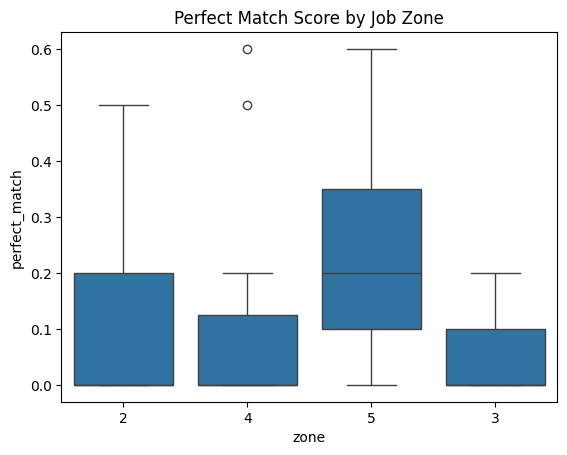

In [152]:
# plot the match score by job zone
sns.boxplot(x='zone', y='perfect_match', data=x)
plt.title('Perfect Match Score by Job Zone')
plt.show()

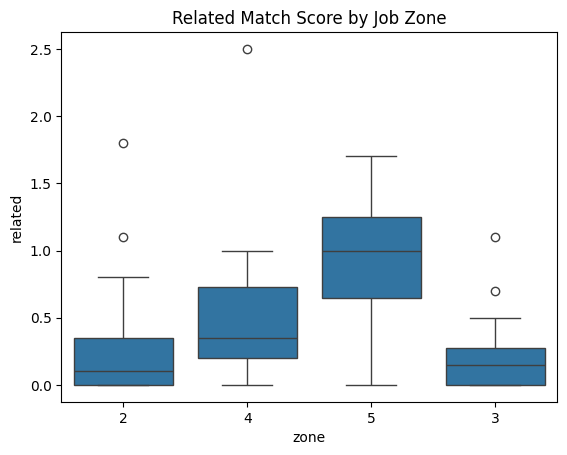

In [153]:
#plot the related score by job zone
sns.boxplot(x='zone', y='related', data=x)
plt.title('Related Match Score by Job Zone')
plt.show()

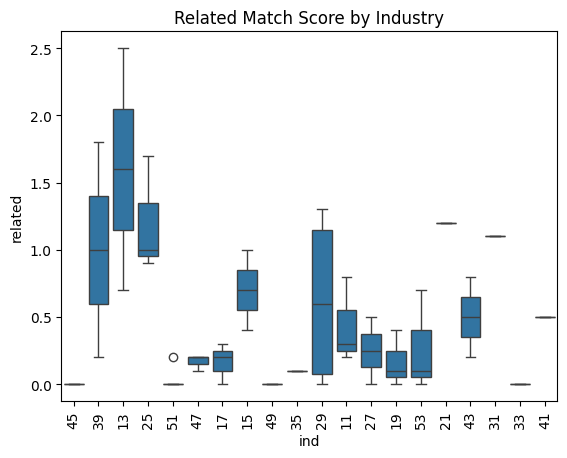

In [154]:
#plot the related score by industry
sns.boxplot(x='ind', y='related', data=x)
plt.title('Related Match Score by Industry')
plt.xticks(rotation=90)
plt.show()


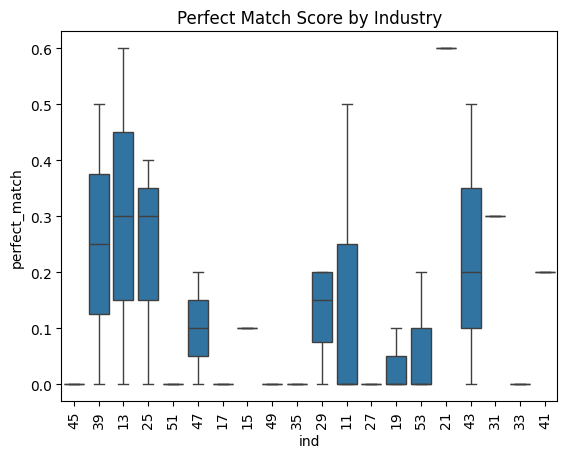

In [155]:
#plot the perfect match by industry
sns.boxplot(x='ind', y='perfect_match', data=x)
plt.title('Perfect Match Score by Industry')
plt.xticks(rotation=90)
plt.show()


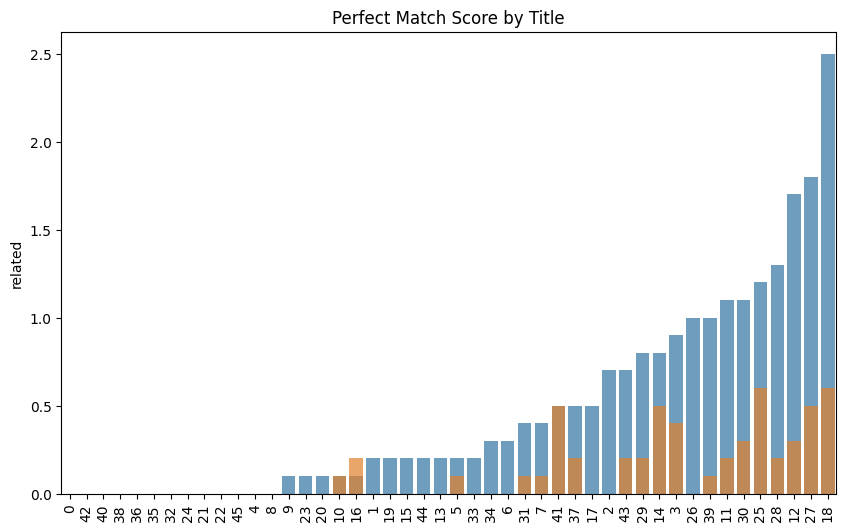

In [156]:
# plot for perfect match by title
plt.figure(figsize=(10, 6))
#x axis is the title, y axis is the score
# make the bars transparent
sns.barplot(x["related"], order=x["related"].sort_values().index, alpha=0.7)
sns.barplot(x["perfect_match"], alpha=0.7)
#plot the related score

#rotate the title
plt.xticks(rotation=90)
#add title
plt.title('Perfect Match Score by Title')
plt.show()


In [160]:
score_df_ind = x.groupby("ind").agg({
    "perfect_match": "mean",
    "related": "mean",
}).reset_index()
score_df_ind

,ind,perfect_match,related
0,11,0.166667,0.433333
1,13,0.300000,1.600000
2,15,0.100000,0.700000
3,17,0.000000,0.166667
4,19,0.033333,0.166667
5,21,0.600000,1.200000
6,25,0.233333,1.200000
7,27,0.000000,0.250000
8,29,0.125000,0.625000
9,31,0.300000,1.100000
